# Data Exploration, Feature Engineering & Statistics for Data Scientists

## Source and Purpose of the Analysis

The dataset was acquired from SF Open Data website. It portraits occurrances registered by SF Police department over 
the past year. The purpose of this analysis is to utilize the concepts learned throughout this course in order to predict violent crime in San Francsico, CA in any given day in 2017. Such project could enable help & rescue teams, such as police, fire department and emergency medical services to prepare for upcoming events and better plan their work.

Statistical anlaysis concepts include:
 * Descriptive Statistics:
     * Summary statistics 
     * Exploratory Data Analysis with vizualizations
 * Inferential Statistics:
     * Hypothesis testing
 * Statistical Modeling/Predictive analytics:
     * Regression analysis

## Possible data collection issues

I consider the observations in my data to be independent and identically distributed (i.i.d.). Howerver, I am aware that dataset can also carry different types of bias, such as selection bias, nonresponse bias, and response bias.

## Getting started...


Let first import the necessary modules.

In [5]:
# imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import scipy.stats as stats
#from scipy.stats import norm
from scipy.stats import binom

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breushpagan
from statsmodels.graphics.correlation import plot_corr
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.genmod.families import family


%matplotlib inline
%pylab inline

random.seed(1234)
sns.set(font_scale=1.5)



Populating the interactive namespace from numpy and matplotlib


Let's load the dataset and peak at the top few rows.

In [6]:
#Loads data from csv into pandas dataframe
df = pd.read_csv('SFPD_Incidents_2016.csv')
df.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120350636,WARRANTS,WARRANT ARREST,Monday,07/11/2016,08:22,TENDERLOIN,"ARREST, BOOKED",0 Block of UNITEDNATIONS PZ,-122.414318,37.779944,"(37.7799444052046, -122.414317857881)",12035063663010
1,120388148,NON-CRIMINAL,CASE CLOSURE,Friday,02/05/2016,00:01,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12038814875030


This dataset looks interesting. It has numerical features, categorical features, and date feature. Let's check the data types to see if they correspond to the dataset metadata. 

In [7]:
# Checking data types in the data frame. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149758 entries, 0 to 149757
Data columns (total 13 columns):
IncidntNum    149758 non-null int64
Category      149758 non-null object
Descript      149758 non-null object
DayOfWeek     149758 non-null object
Date          149758 non-null object
Time          149758 non-null object
PdDistrict    149757 non-null object
Resolution    149758 non-null object
Address       149758 non-null object
X             149758 non-null float64
Y             149758 non-null float64
Location      149758 non-null object
PdId          149758 non-null int64
dtypes: float64(2), int64(2), object(9)
memory usage: 14.9+ MB


Another first approach in exploration, would be to examine the shape of the dataset we are workign with. 

In [8]:
df.shape

(149758, 13)

Wow. There are around 150k events in our dataset. That seems to be more than enough to run an experiment and one could expect to have a pretty decent result.

It looks like there is still some clean up to do in the column labels. "Y" column corresponds to latitude, and "X" to longitude, so let's replace those labels to reflect that information. Let's make all labels lower case across the dataset as well. 

In [9]:
df = df.rename(index=str, columns={"X": "lat", "Y": "long"})
df = df.rename(columns=lambda x : x.lower())
df.head(2)

,incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,lat,long,location,pdid
0,120350636,WARRANTS,WARRANT ARREST,Monday,07/11/2016,08:22,TENDERLOIN,"ARREST, BOOKED",0 Block of UNITEDNATIONS PZ,-122.414318,37.779944,"(37.7799444052046, -122.414317857881)",12035063663010
1,120388148,NON-CRIMINAL,CASE CLOSURE,Friday,02/05/2016,00:01,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12038814875030


# Visualizing Crime Data in SF

In order to visualize the crime data geographocally, I have chosen the Folium's package. The tileset of choice is OpenStreetMap (which is default); however, Folium can be used with other tilesets like Mapbox or Cloudmade too.

As per Folium's documentation:

"Folium makes it easy to visualize data that’s been manipulated in Python on an interactive Leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing Vincent/Vega visualizations as markers on the map."

[Folium Documentation]("https://pypi.python.org/pypi/folium")

In [10]:
# Imports folium package and plugins
import folium
from folium import plugins
from folium.plugins import MarkerCluster

Runnig the code below will create a map with location markers that are clustered if close together. 

In [11]:
# for speed purposes
SF_COORDINATES = [37.73, -122.40]

# creates an empty map zoomed in San Francisco
map = folium.Map(location=SF_COORDINATES, zoom_start=12)

# creates a marker cluster called "Crime cluster"
marker_cluster = folium.MarkerCluster("Crime Cluster").add_to(map) 

#add a marker for each event, add it to the cluster, not the map
for each in df[:100].iterrows(): # for speed purposes delimited data to 15K
    folium.Marker(location = [each[1]['long'],each[1]['lat']]).add_to(marker_cluster)
    
display(map)
# One can save a map as a html file by using map.create_map(path='map.html') 

# Data cleaning

As per previous output, even though the dataset contains time series data (Day of the Week, Date, Time), the data type is not defined as so. Let's convert the Date, Time, and Day of the Week  from string to numerical data types.

#### Type casting the Date column

In [502]:
def split_date(str_date):
    ''' This function splits the column "Date" in the SFPD into month, day and year. '''
    month, day, yr = str_date.split('/')
    return int(month), int(day), int(yr)

In [503]:
# Apply function to split date of each observation of date feature in the data set
df['yr'] = df.date.apply(lambda x: split_date(x)[2])
df['day_month'] = df.date.apply(lambda x: split_date(x)[1])
df['month'] = df.date.apply(lambda x: split_date(x)[0])

In [504]:
df.head(2)

,incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,lat,long,location,pdid,yr,day_month,month
0,120350636,WARRANTS,WARRANT ARREST,Monday,07/11/2016,08:22,TENDERLOIN,"ARREST, BOOKED",0 Block of UNITEDNATIONS PZ,-122.414318,37.779944,"(37.7799444052046, -122.414317857881)",12035063663010,2016,11,7
1,120388148,NON-CRIMINAL,CASE CLOSURE,Friday,02/05/2016,00:01,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12038814875030,2016,5,2


#### Type casting Time column

Looks like the time column is not of date type structure. Let's change it.

In [505]:
def split_time(str_time):
    ''' This function splits the column "time" in the SFPD into hour and minutes. '''
    hr, minutes = str_time.split(':')
    return int(hr), int(minutes)

In [506]:
# Apply function to split time to each observation of time in the data set
df['hr'] = df.time.apply(lambda x: split_time(x)[0])
df['minutes'] = df.time.apply(lambda x: split_time(x)[1])

In [507]:
# Returns a index list of column labels
df.columns

Index(['incidntnum', 'category', 'descript', 'dayofweek', 'date', 'time',
       'pddistrict', 'resolution', 'address', 'lat', 'long', 'location',
       'pdid', 'yr', 'day_month', 'month', 'hr', 'minutes'],
      dtype='object')

#### Type Casting the Day of The Week column

In [508]:
# Transforms week days into numerical values
df.dayofweek.replace({"Sunday":0,"Monday":1,"Tuesday":2,
                      "Wednesday":3, "Thursday":4,"Friday":5,
                      "Saturday":6}, inplace=True)
df.head(2)

,incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,lat,long,location,pdid,yr,day_month,month,hr,minutes
0,120350636,WARRANTS,WARRANT ARREST,1,07/11/2016,08:22,TENDERLOIN,"ARREST, BOOKED",0 Block of UNITEDNATIONS PZ,-122.414318,37.779944,"(37.7799444052046, -122.414317857881)",12035063663010,2016,11,7,8,22
1,120388148,NON-CRIMINAL,CASE CLOSURE,5,02/05/2016,00:01,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12038814875030,2016,5,2,0,1


### Check for Missing Values

Let's check for missing/null values in the dataset.

In [509]:
# Count for each feature
df.count()

incidntnum    149758
category      149758
descript      149758
dayofweek     149758
date          149758
time          149758
pddistrict    149757
resolution    149758
address       149758
lat           149758
long          149758
location      149758
pdid          149758
yr            149758
day_month     149758
month         149758
hr            149758
minutes       149758
dtype: int64

Looks like one pddistric value is missing. Let's visualize it:

In [510]:
# Returns observation where NaN exists
df[df.pddistrict.isnull() == True]

,incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,lat,long,location,pdid,yr,day_month,month,hr,minutes
131349,166018573,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,0,01/17/2016,23:54,NaN,NONE,100 Block of VELASCO AV,-122.413352,37.708202,"(37.7082024584902, -122.413351985284)",16601857306244,2016,17,1,23,54


Let's replace the null value with what we believe is the correct input. Looks like it should be "INGLESIDE".

In [511]:
# Returns a series where address matches the same one as of missing value, and what missing value should be
df[df.address == "100 Block of VELASCO AV"]["pddistrict"]

131349    NaN
Name: pddistrict, dtype: object

In [512]:
# Replace NaN with "Ingleside"
df.fillna("INGLESIDE", inplace = True)

In [513]:
# Checks for null values in the pddistrict column
f'{"Number of NaN:"}{" "}{df.pddistrict.isnull().sum()}'.format()

'Number of NaN: 0'

### Drop Irrelevant Features

Some of the features will not contribute to our analysis, so let's get rid

In [514]:
# Eliminates columns we will not use for analysis
df = df.drop(['pdid', 'resolution', 'location', 'incidntnum', 'date', 
              'time', 'descript', 'address', 'pddistrict'], axis=1)
df.head(2)

,category,dayofweek,lat,long,yr,day_month,month,hr,minutes
0,WARRANTS,1,-122.414318,37.779944,2016,11,7,8,22
1,NON-CRIMINAL,5,-122.403405,37.775421,2016,5,2,0,1


# Exploratory Data Analysis

Let's just take a peak at the summary statistics. We particularly want to look at spread (min,max), variation (std), mean (center location), and skewness. 

In [515]:
df.describe()

,dayofweek,lat,long,yr,day_month,month,hr,minutes
count,149758.000000,149758.000000,149758.000000,149758.0,149758.000000,149758.000000,149758.000000,149758.000000
mean,3.075034,-122.423593,37.768927,2016.0,15.769148,6.530089,13.451876,20.575048
std,1.996876,0.026202,0.023629,0.0,8.855288,3.471725,6.436752,18.595105
min,0.000000,-122.513642,37.707922,2016.0,1.000000,1.000000,0.000000,0.000000
25%,1.000000,-122.434036,37.756486,2016.0,8.000000,4.000000,9.000000,0.000000
50%,3.000000,-122.416903,37.775421,2016.0,16.000000,7.000000,14.000000,20.000000
75%,5.000000,-122.406605,37.785063,2016.0,23.000000,10.000000,19.000000,34.000000
max,6.000000,-122.365565,37.819975,2016.0,31.000000,12.000000,23.000000,59.000000


#### Events by Category

I decided to draw a bar plot to show number of crimes in each category. Bar plots indicate that the top crime categroy is Larceny/Theft. Further, top 20 crime types account for 98% of the crimes.

In [516]:
# Percentage of top 20 crimes
f'{(df.category.value_counts()[:20].sum())/(df.category.value_counts().sum()):.02}'.format()

'0.98'

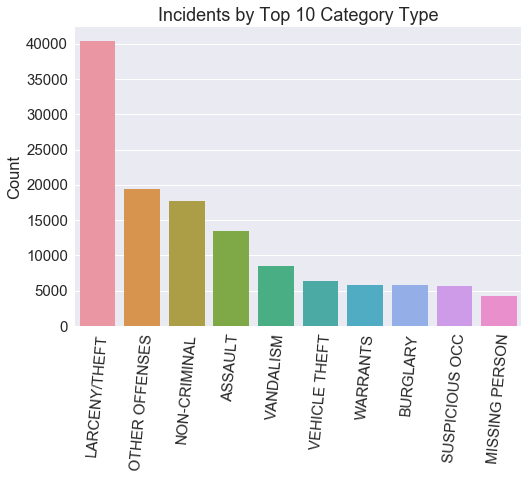

In [517]:
#Barplot of the count of the category column in the SFPD dataframe
cat = pd.DataFrame(df.category.value_counts())
cat = cat.reset_index()

sns.barplot(x=["LARCENY/THEFT","OTHER OFFENSES","NON-CRIMINAL",
               "ASSAULT","VANDALISM","VEHICLE THEFT","WARRANTS", 
               "BURGLARY", "SUSPICIOUS OCC", "MISSING PERSON"], 
            y=cat.category.head(10))
plt.xticks(rotation=85);
plt.ylabel("Count");
plt.title("Incidents by Top 10 Category Type");

In [518]:
# Another way to calculate counts of event in the crime data set
# df[['category']].apply(lambda x: x.value_counts())

### Variation in Crime
Plots below show trends in crime for four main date factors: hour, day of week, day of month, and month of the year.

#### Crime by Week day

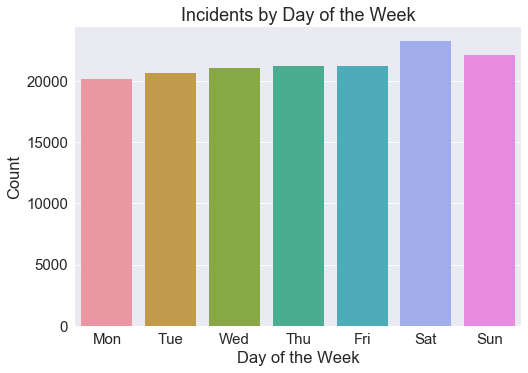

In [519]:
# Distribution of the incidents as per day of the week. 
dow_count = df.groupby('dayofweek').count()
dow_cat_count = dow_count['category'].values

sns.barplot(x=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], y=dow_cat_count); 
plt.xticks(rotation=0);
plt.ylabel("Count");
plt.xlabel("Day of the Week");
plt.title("Incidents by Day of the Week");

**Day of week**: Crime rates change during the week. Crime incidents are higher on Saturdays, and lowest on Mondays.

#### Events by Day of Month

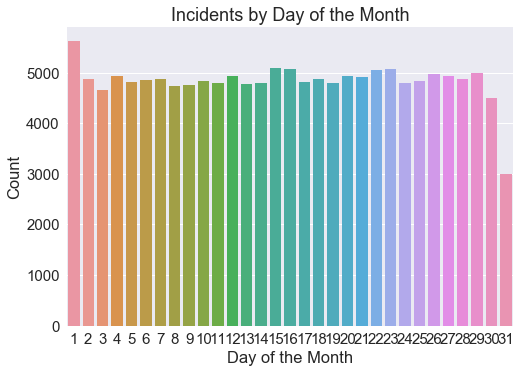

In [520]:
# Distribution of the incidents as per day of the week. 
dom_count = df.groupby('day_month').count()
dom_cat_count = dom_count['category'].values
day = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

sns.barplot(x=day, y=dom_cat_count); 
plt.xticks(rotation=0);
plt.ylabel("Count");
plt.xlabel("Day of the Month");
plt.title("Incidents by Day of the Month");

**Day of Month** 

#### Events by Month

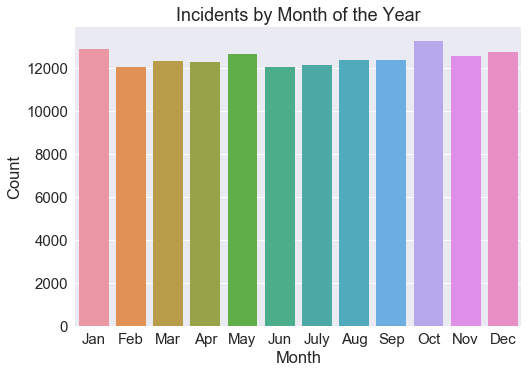

In [521]:
# Distribution of the incidents as per hour of the day. 
month_count = df.groupby('month').count()
month_cat_count = month_count['category'].values

sns.barplot(x=["Jan","Feb","Mar","Apr","May", 
               "Jun","July", "Aug", "Sep", "Oct", 
               "Nov","Dec"], y=month_cat_count); 
plt.xticks(rotation=0);
plt.ylabel("Count");
plt.xlabel("Month");
plt.title("Incidents by Month of the Year");

**Month**: Crime rate is highest during October, and lowest in June. Crime seems to follow a bimodal pattern with peaks in May and October and valleys in February and June.

#### Events by Hour of Day 

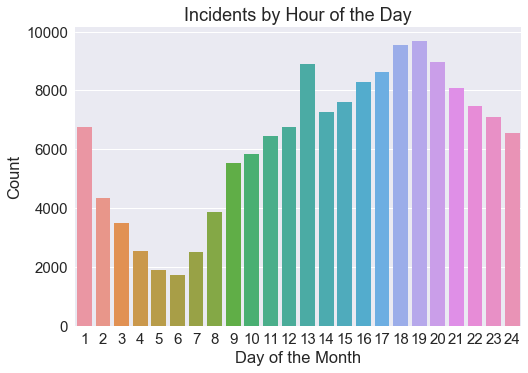

In [522]:
# Distribution of the incidents as per hour of the day. 
hr_count = df.groupby('hr').count()
hr_cat_count = hr_count['category'].values
hr = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

sns.barplot(x=hr, y=hr_cat_count); 
plt.xticks(rotation=0);
plt.ylabel("Count");
plt.xlabel("Day of the Month");
plt.title("Incidents by Hour of the Day");

**Hour**: Crime vs Hour of day shows a gruadual reduction in crime from midnight to 6 am, after which it rises from 5 am to 9 am exponentially, and remains at sustained high level until midnight.


## Violent vs Nonviolent Crime

Given we are trying to predict the probability of an event happening and the type of the event that will take place, one must transform the categorical target variable into a binary outcome. Thus, let's divide the crimes into violent and nonviolent. 

In [523]:
# Creates binary response variable to establish rather an event in category is violent or not. 
violent_list = ["ASSAULT","ROBBERY", "KIDNAPPING", "SEX OFFENSES, FORCIBLE"]
df["is_violent"] = df["category"].isin(violent_list)

Let's plot the distribution of crimes as violent (True) or nonviolent (False).

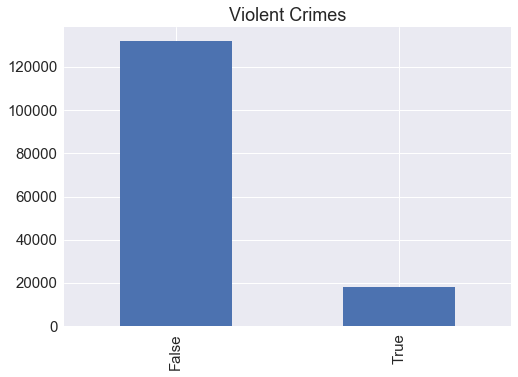

In [524]:
# Bar graph of count of crimes as violent or not
ax =df["is_violent"].value_counts().plot(kind='bar', title='Violent Crimes');

Not great but we'll move on.

In [525]:
df_violent = df[df['is_violent']] # Dataframe with only violent crimes
df_non_violent = df[~df['is_violent']] # Dataframe with only nonviolent crimes
dow_violent = df_violent.groupby('dayofweek').count() # Dataframe with only violent crimes count by day of week
dow_non_violent = df_non_violent.groupby('dayofweek').count() # Dataframe with only nonviolent crimes count by day of week
violent_count = dow_violent['category'].values # Array with count of violent crimes
non_violent_count = dow_non_violent['category'].values # Array with count of nonviolent crimes

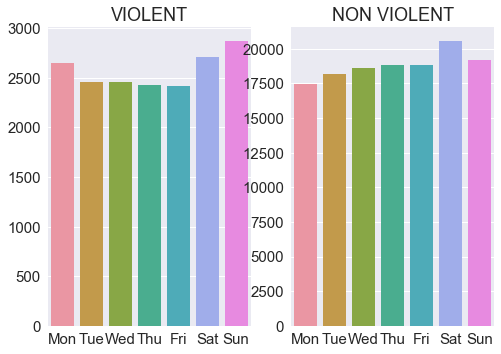

In [526]:
f, ax = plt.subplots(1,2)

sns.barplot(x=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], y=violent_count, ax=ax[0])
sns.barplot(x=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], y=non_violent_count, ax=ax[1])

ax[0].set_title("VIOLENT")
ax[1].set_title("NON VIOLENT");

It seems most violent crimes occur during the weekend while nonviolent crimes are a gradual distribution aside from Saturdays. 

This is a visualization of the violent and non-violent incidents by month.


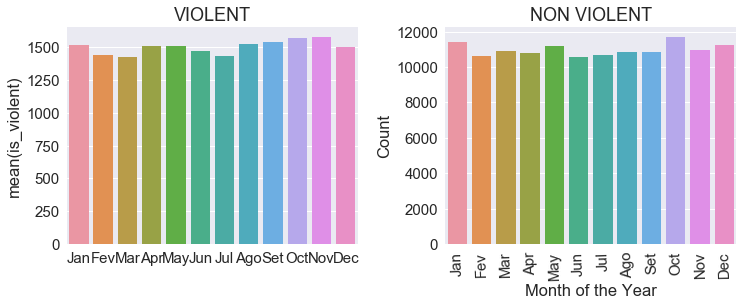

In [527]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

count_violence_months = df_violent.groupby("month").count()
count_non_violence_months = df_non_violent.groupby("month").count()

plt.figure(figsize = (12,12))
ax = [plt.subplot(2,2,i+1) for i in range(2)]
plt.subplots_adjust(wspace=.3, hspace=1)
sns.barplot(x=["Jan","Fev","Mar","Apr","May","Jun","Jul","Ago","Set", "Oct", "Nov", "Dec"], 
            y=count_non_violence_months.is_violent, ax=ax[1])
sns.barplot(x=["Jan","Fev","Mar","Apr","May","Jun","Jul","Ago","Set", "Oct", "Nov", "Dec"], 
            y=count_violence_months.is_violent, ax=ax[0])
plt.xlabel("Month of the Year")
plt.ylabel("Count")
plt.xticks(rotation=92);

ax[0].set_title("VIOLENT");
ax[1].set_title("NON VIOLENT");
print("This is a visualization of the violent and non-violent incidents by month.")

Looks like the end of the year are the most violent months while June and July are the least violent.

## Analyzing the Distribution of Violent Crimes by hour

Let's start by looking at what kind of crimes make up the violent category. 

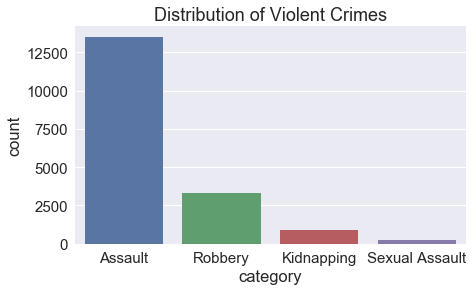

In [528]:
# 0 = Assault, 1 = Robbery, 2 =  Kidnapping, 3 = Sexual Assault
fig, ax = plt.subplots(figsize=(7,4))
ax = sns.countplot(x="category", data=df_violent)
ax.axes.set_xticklabels(["Assault","Robbery","Kidnapping", "Sexual Assault"]);
ax.axes.set_title("Distribution of Violent Crimes");

Cleary, the majority of incidents are assaults. Later on we will look at the percentages of each category. 

A good way to understand the distribution of each category of crimes is to use boxplots. Boxplots allows to easily check for outliers, skeweness, location of center, and variation of observations. 

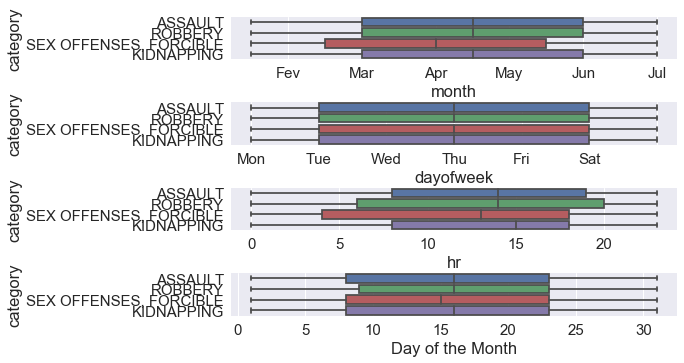

In [529]:
x_variable = df[(df.category == "ASSAULT") | (df.category == "ROBBERY") | (df.category == "KIDNAPPING") | (df.category == "SEX OFFENSES, FORCIBLE") ]

f, ax = plt.subplots(4,1)
plt.subplots_adjust(wspace=.3, hspace=1)

ax1 = sns.boxplot(x_variable["month"], x_variable["category"], ax=ax[0]);
ax2 = sns.boxplot(x_variable["dayofweek"], x_variable["category"], ax=ax[1]);
ax3 = sns.boxplot(x_variable["hr"], x_variable["category"], ax=ax[2]);
ax4 = sns.boxplot(x_variable["day_month"], x_variable["category"], ax=ax[3]);

ax1.axes.set_xticklabels(["Jan","Fev","Mar","Apr","May","Jun","Jul","Ago","Set", "Oct", "Nov", "Dec"]);
ax2.axes.set_xticklabels(["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]);
ax4.axes.set_xlabel("Day of the Month");

### Assault

Let's start by looking at the assault category.

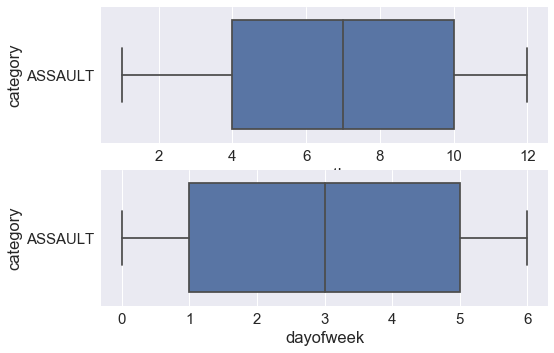

In [530]:
# Plots BOX Plots for the ASSAULT category
f, ax = plt.subplots(2,1)

sns.boxplot(df[df.category == "ASSAULT"]["month"], df[df.category == "ASSAULT"]["category"], ax=ax[0]);
sns.boxplot(df[df.category == "ASSAULT"]["dayofweek"], df[df.category == "ASSAULT"]["category"],ax=ax[1]);

Assault seems to be a little left skewed on its monthly distribution, but pretty symmetric on by day of week. It does not seem to have any outliers, which is good. Let's check the distirbution of each numerical feature in the assault category with bar plots. 

The distribution of assaults by hour seems interesting. Let's see if we can try fitting a distribution that we know. 

/Users/vivianemarani/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(0, 23)

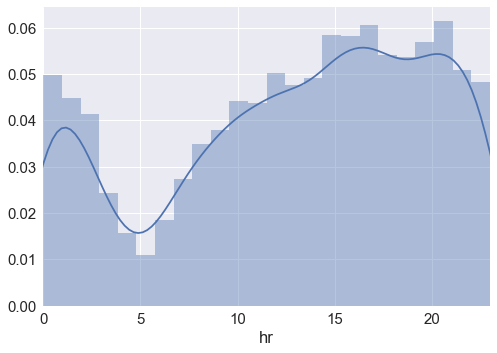

In [531]:
ax = sns.distplot(df[df.category == "ASSAULT"]["hr"], kde=True, bins=24);
ax.axes.set_xlim(0,23)

It looks like this kde (kernel densty estimate) is a pretty good fit for this ditribution; however, it is not one we understand. A good approach would be to model a segment of this, i.e. between hours 12am-3am, as normally distributed. 

### Robbery

A good way to understand the distribution of each category of crimes is to use boxplots. Boxplots allows to easily check for outliers, skeweness, location of center, and variation of observations.

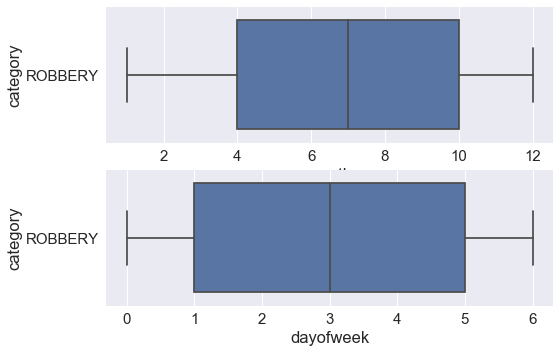

In [532]:
# Plots BOX Plots for the ROBBERY category

f, ax = plt.subplots(2,1)

sns.boxplot(df[df.category == "ROBBERY"]["month"], df[df.category == "ROBBERY"]["category"], ax=ax[0]);
sns.boxplot(df[df.category == "ROBBERY"]["dayofweek"], df[df.category == "ROBBERY"]["category"], ax=ax[1]);


Robbery seems to be a little left skewed on its monthly distribution, but pretty symmetric on by day of week. It does not seem to have any outliers, which is good. Let's check the distirbution of each numerical feature in the assault category with bar plots.

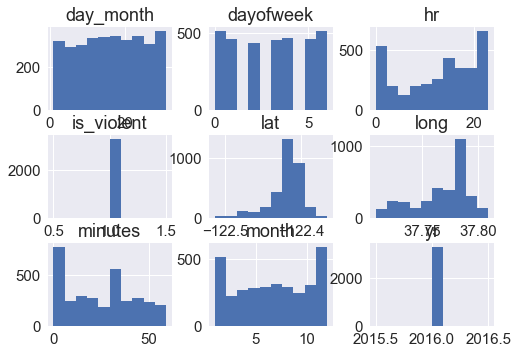

In [533]:
# Plots distributions for the ROBBERTY category
df[df.category == "ROBBERY"].hist();

Again, let's look at the distribution of robberies by hour in order to check if it is one that we know and maybe test a fit. 

/Users/vivianemarani/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(0, 23)

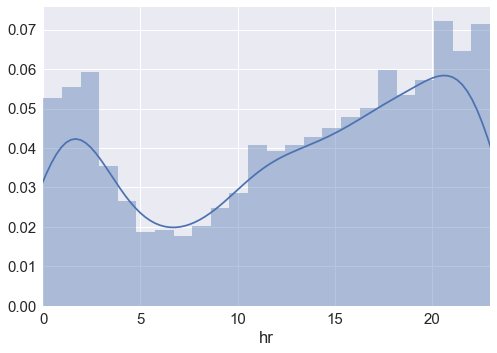

In [534]:
ax = sns.distplot(df[df.category == "ROBBERY"]["hr"], kde=True, bins=24);
ax.axes.set_xlim(0,23)

It looks like this is a pretty good fit for this ditribution; however, it is not one we understand. A good approach would be to model a segment of this, i.e. between hours 12am-5am, as normally distributed. 

### Kidnapping

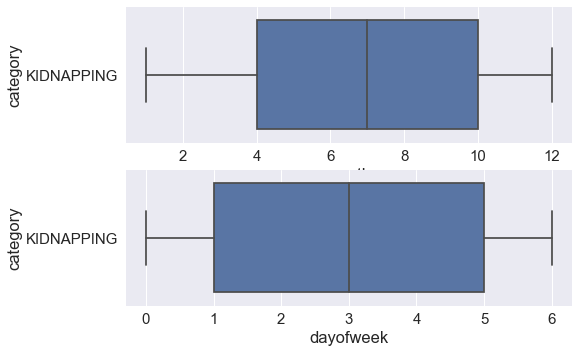

In [535]:
# Plots BOX Plots for the KIDNAPPING category

f, ax = plt.subplots(2,1)

sns.boxplot(df[df.category == "KIDNAPPING"]["month"], df[df.category == "KIDNAPPING"]["category"], ax=ax[0]);
sns.boxplot(df[df.category == "KIDNAPPING"]["dayofweek"], df[df.category == "KIDNAPPING"]["category"], ax=ax[1]);



Kidnapping seems to be a little left skewed on its monthly distribution, but pretty symmetric on by day of week. It does not seem to have any outliers, which is good. Let's visualize all the distributions for each numerical feature in this category.

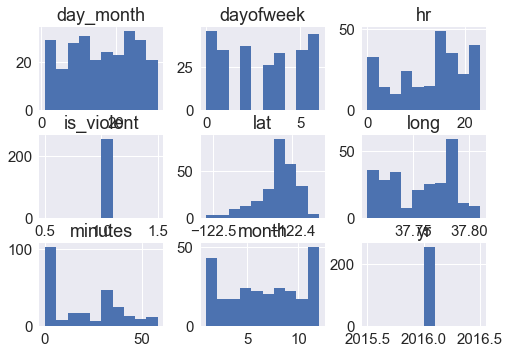

In [536]:
# Plots distributions for the KIDNAPPING category
df[df.category == "KIDNAPPING"].hist();

Just like previously, let's look at the hour distribution for the kidnapping category. 

/Users/vivianemarani/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(0, 23)

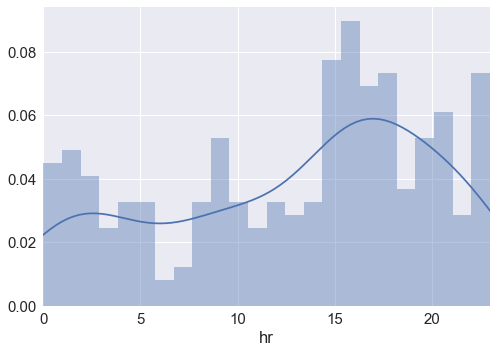

In [537]:
ax = sns.distplot(df[df.category == "KIDNAPPING"]["hr"], kde=True, bins=24);
ax.axes.set_xlim(0,23)

It does not look like this is a good fit, it is also not any ditribution we know. 

### FORCIBLE SEX OFFENSES

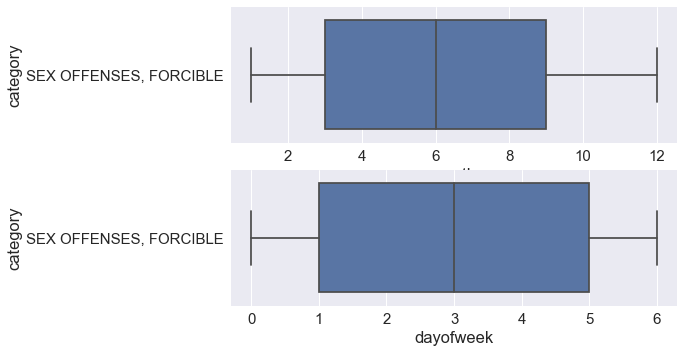

In [538]:
# Plots BOX Plots for the SEX OFFENSES, FORCIBLE category
f, ax = plt.subplots(2,1)

sns.boxplot(df[df.category == "SEX OFFENSES, FORCIBLE"]["month"], df[df.category == "SEX OFFENSES, FORCIBLE"]["category"], ax=ax[0]);
sns.boxplot(df[df.category == "SEX OFFENSES, FORCIBLE"]["dayofweek"], df[df.category == "SEX OFFENSES, FORCIBLE"]["category"], ax=ax[1]);

Unlike the other categories, sex offenses seems to be a little right skewed on its monthly distribution. However, it is pretty symmetric on by day of week like the other categories of violent crime. It does not seem to have any outliers, which is good. Let's check the distirbution of each numerical feature in the assault category with bar plots. Let's visualize all the distributions for each numerical feature in this category.

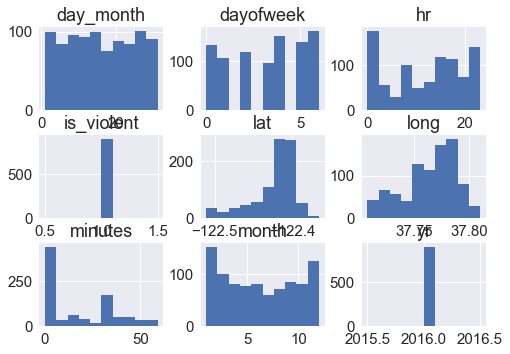

In [539]:
# Plots distributions for the SEX OFFENSES, FORCIBLE category
df[df.category == "SEX OFFENSES, FORCIBLE"].hist();

For the last category of violent crime, let's look at the hour distribution. 

/Users/vivianemarani/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


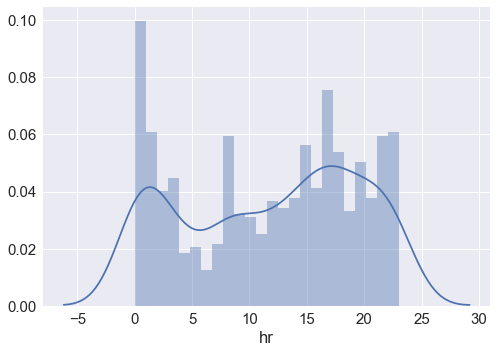

In [540]:
sns.distplot(df[df.category == "SEX OFFENSES, FORCIBLE"]["hr"], kde=True, bins=24);

It does not look like this is a good fit, it is also not any ditribution we know. An alternative would be to apply the CLT (Central Limit Theorem), i.e. draw many samples of size at least 30 in order to make inference. 

# Probabilities

As we explore the probability distributions of crimes, let's actually try to find out the probability of having a violent crime in the first place, and later, find the conditional probabilities of each category of violent crime given crime is violent. 

#### Probability of violent crime

In [541]:
# Calculates the frequency of violent crimes
total_violent = len(df_violent)
total_crime = len(df)
prob_assault = total_violent/total_crime
print("Probability of violent on any given time and day is",f'{prob_assault:.02}'.format())

Probability of violent on any given time and day is 0.12


P(violent) = $\frac {number of violent crimes}{number of crimes}$

### Conditional probability

#### Probability of assult given crime is violent

In [542]:
# Calculates the frequency of assult 
number_of_assault = len(df_violent[df_violent.category=="ASSAULT"])
number_of_violent_crime = len(df_violent)
prob_assault = number_of_assault/number_of_violent_crime
print("Probability of assault, given the crime is violent, is",f'{prob_assault:.02}'.format())

Probability of assault, given the crime is violent, is 0.75


#### Probability of robbery given crime is violent

P(robbery) = $\frac {number of robberies}{number of violent crimes}$

In [543]:
# Calculates the frequency of robbery 
number_of_robbery = len(df_violent[df_violent.category=="ROBBERY"])
prob_robbery = number_of_robbery/number_of_violent_crime
print("Probability of robbery, given the crime is violent, is",f'{prob_robbery:.02}'.format())

Probability of robbery, given the crime is violent, is 0.18


#### Probability of kidnapping given crime is violent

P(kidnapping) = $\frac {number of kidnappings}{number of violent crimes}$

In [544]:
# Calculates the frequency of kidnapping 
number_of_kidnapping = len(df_violent[df_violent.category=="KIDNAPPING"])
prob_kidnapping = number_of_kidnapping/number_of_violent_crime
print("Probability of kidnapping, given the crime is violent, is",f'{prob_kidnapping:.02}'.format())

Probability of kidnapping, given the crime is violent, is 0.014


#### Probability of assult given crime is violent

In [545]:
# Calculates the frequency of Sex Offenses 
number_of_sex_offense = len(df_violent[df_violent.category=="SEX OFFENSES, FORCIBLE"])
prob_sex_offense = number_of_sex_offense/number_of_violent_crime
print("Probability of forcible sex offense, given the crime is violent, is",f'{prob_sex_offense:.02}'.format())

Probability of forcible sex offense, given the crime is violent, is 0.051


### Maximum Likelihood Estimate (MLE ):  Hour to likely have an assault

We know that violent crimes by hour is not normally distributed. However, if we assumes it was, we could then ask for the highest likelihood by hour of being assault. 

In [546]:
# Series of assaults by hour
data = df_assault.hr

In [547]:
def normal_likelihood(m, data):
    "For a given mean, find the product of all likelihoods (the pdf for the observed data)"
    return np.product(stats.norm(m,1000).pdf(data))

In [548]:
# Arbitrarily define a range, i.e. a prior. We think the best estimate is somewhere in there.
range_of_means = np.linspace(0, 24)
range_of_means[:3]

array([ 0.        ,  0.48979592,  0.97959184])

In [549]:
# Let's find all the likelihoods.
likelihoods = [normal_likelihood(m, data) for m in range_of_means]
likelihoods[:5] # Underflow!!!! 

[0.0, 0.0, 0.0, 0.0, 0.0]

Looks like there is an underflow while taking the first derivative of the product. Let's take the log of the likelihood as the sum of the first derivative is an easier calculation than the product.

The log-likelihood function is
![](https://www.statlect.com/images/normal-distribution-maximum-likelihood__10.png)

In [550]:
# Log likelihood function
def normal_log_likelihood(m, data):
    "Let's pull the log trick! Calculate the log-likelihoods. Remember to switch to sum!"
    return sum(np.log(stats.norm(m, 1000).pdf(data)))

In [551]:
# Let's find all the log likelihoods. For each candidate mean (estimate of µ), let's see how well it would fit the observed data
loglikelihoods = [normal_log_likelihood(m, data) for m in range_of_means]
loglikelihoods[:3]

[-105920.10909282409, -105920.02453896488, -105919.94323167292]

In [552]:
# For this window of means where is the peak
top_of_the_mountain = range_of_means[np.argmax(loglikelihoods)]
f"{top_of_the_mountain:.4}"

'13.22'

MLE is 13.2244897959


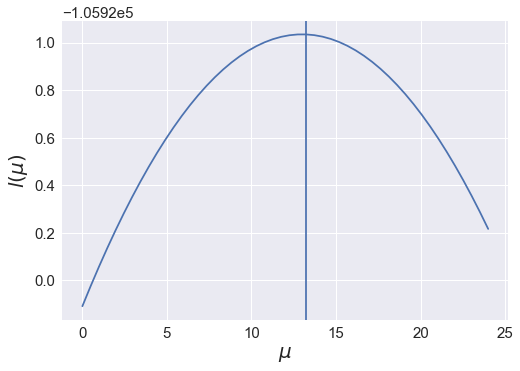

In [553]:
# Ploting the log-likelihoods
# We want the "top of the mountain", aka where the derivative is zero in a monotonically increasing function
fig = plt.figure().add_subplot(111)
fig.plot(range_of_means, loglikelihoods)
fig.set_xlabel('$\mu$', fontsize=20)
fig.set_ylabel('$l(\mu)$', fontsize=20);

axvline(x = top_of_the_mountain);
print("MLE is", top_of_the_mountain)

If the distribution of assaults by hour was normally distributed, it looks like, on average, we are most likely to be assaulted around 1pm.

# Point Estimate

There are two ways to learn about population paremeters ($\theta$) for inference:
    * 1) Hypothesis testing 
    * 2) Confidence Intervals
    

## Hypothesis Testing

### One sample: two tails
After 50 reports of violent crime, SF police departments claims that assaults account for 45% of all violent crimes. 

* 1) Null Hypothesis

$$H_o: p_o = 45%$$

$$H_a: p_o \neq 45%$$

* 2) Significance Level

$$\sigma = .05$$

* 3) Test-statistics

$$ z-score = \frac{{p_1} - {p_o} }{\sqrt \frac{p(1-p)}{n}} $$

* 4) Confidence Interval:

$$ \hat{p} \pm 1.96 \sqrt {\frac{p(1-p)}{n}} $$

In [554]:
α = 0.05 # significance value
n = 50 # number of violent events
p_o = .45 # probability of assault stated by SFPD
p = .75 # sample frequency of assault for 2016, calculated previously

In [555]:
# Calculates stantard error of p
se = np.sqrt(p*(1-p)/n)
se

0.06123724356957945

In [556]:
# Calculates the z-score
z_score = (p-p_o)/se
z_score

4.8989794855663567

In [557]:
## Calculates p-value for observed t-statistic 
p_value = stats.norm.cdf(z_score)
p_value

0.9999995183214957

The p-value is greater than 0.05; therefore, we fail to reject the null hypothesis. There's not enough evidence to support that assaults do happen 45% of the time.

A Type I error (False Positive) would be to claim that on average assaults happen 45% of the time there is a violent assault, when it doesn't.

A Type II error (False Negative) would be to claim that on average assaults do not happen 45% of the time there is a violent crime, when it does.

## Confidence Interval

In [558]:
n = 50 # number of observations
p = .45 # probability of rain follows a binomial distribution
α = 0.05 # significance value

In [559]:
#calculate the z-score 
z_score = stats.norm(0,1).ppf(1 - α/2) #a/2: two tails
f'{z_score:.4}'.format() 

'1.96'

In [560]:
# calculate the sample standard error for one proportion
se = (p*(1-p)/n)**.5
#se = round(se*100,2)
f'{se:.2}'.format()

'0.07'

In [561]:
# calculate confidence interval
upper_bound = .45 + (z_score*se) # z_score*se = margin of error
lower_bound = .45 - (z_score*se) # z_score*se = margin of error

print("The 95% confidence interval for the mean is between {:.2%} and {:.2%}".format(lower_bound, upper_bound))

The 95% confidence interval for the mean is between 31.21% and 58.79%


Given our estimate of 45% is contained in the confidence interval, we fail to reject the null hypothesis. There's not enough evidence to support that assaults do happen 45% of the time.

# Statistical Modeling: Predicting Probability of Violent Crime

In [562]:
df_violent.category.replace({'ASSAULT':0,'ROBBERY':1,'KIDNAPPING':2, 'SEX OFFENSES, FORCIBLE':3},inplace=True)
df_violent.head(2)

/Users/vivianemarani/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,category,dayofweek,lat,long,yr,day_month,month,hr,minutes,is_violent
8,0,0,-122.396716,37.754860,2016,24,7,18,30,True
14,0,5,-122.394485,37.787298,2016,1,1,1,30,True


In order to determine the probability of observing a violent crime, one must proceed with regression analysis. Some of the linear regression models we covered in this class were: Simple Linear Regression Model, Logistic Regression, General Linear Regression Model. Let's try exploring each one of those.

While we will attemp to test the waters for each type of regression analysis, we know that only one type is the most appropriate for what we are trying to answer. In this case, I am interedted in determining the probability of having a violent crime given certain attributes such as latitude, longitude, hour, day of the week, day of the month, and month of the year. The best regression analysis for this type of question would be logistic regression since we are looking for an outcome that is binary (yes = violent crime, no = nonviolent crime). Lastly, we must convert Yes and No to numeric, 1 and 0 respectively. 

In [563]:
# Converting violent into binary variable
df["violent"] = np.where(df['is_violent'] == True, 1, 0)

## Linear Regression

In this section, we will try to predict rather a crime is violent given a certain hour of the day. Let's start with trying to run a **Simple Linear Regression** through the data.

#### Outline for performing simple linear regression would be:
 * 1) Make sure reponse and explanatory variable are both continuous
 * 2) Run stats model and analyise goodness of fit (R-squared) and coeficients and intercept params.
 * 3) Interpret results:
 
 "Increasing $x_i$ by 1 unit increases/decreases the outcome by _______."
 
 *  4) Check if assumptions are met and if you can validate the model

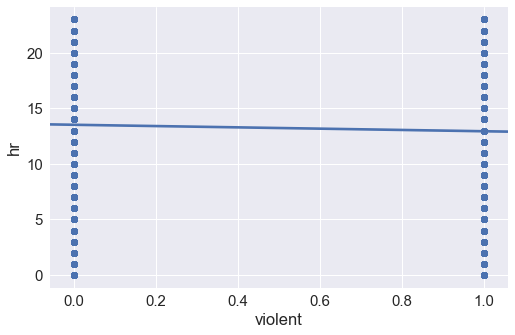

In [564]:
sns.lmplot(x='violent', y='hr', data=df, aspect=1.5);

As discussed previously, the outcome is a binary response that follows a Binomial Distribution but we will proceed with interpreting the results from the model.

In [565]:
model = smf.ols("violent ~ hr", data=df).fit().summary()

**Hypothesis testing**:

Using a significance level of 0.05.

$H_0: \beta_1 = 0$

$H_a: \beta_1 \neq 0$

The F-statistic of the model is 129.9 and the p-value is 4.44e-30.
Since the p-value is less than 0.05, we reject the null hypothesis and conclude that the coefficient of hr is statistically significant.

** Goodness of Fit**: $R^2$

The percentage of the variation in y can be explained by 
the corresponding variation in the explanator variable (hr) is and the ordinary-least-squares line is 0.1%, and the unexplained percentage of variation is 100% – 0.1% = 99%.

**Model Interpretation**
* Hr: For each unit increase in hour, violent crime will decrease by -0.0015
* Intercept: In this case it is not useful to interpret the intercept as that is representation of the mean violent crimes if all the explanatory variables take on the value of 0. However, hour cannot be non-existent. We always have the element of time. 

Again, a simple linear regression will not be the best approach for this problem, hower, we will proceed with testing the assumptions anyways. 

### Assumption for Linear Regression:
* **Linearity**: there must be a linear relationship between the parameters
* **I.I.D.**: Independent and Identically Distributed observations
* **Normality**: errors must be normally distributed
* **Constant Variance**: erros must have constant variance (no heteroscedasticity) 

## Stepwise Linear Regression: Backwards

In [155]:
smf.ols("violent ~ dayofweek + lat + long + day_month + month + hr", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                violent   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     214.2
Date:                Thu, 09 Mar 2017   Prob (F-statistic):          2.40e-273
Time:                        07:14:00   Log-Likelihood:                -43616.
No. Observations:              149758   AIC:                         8.725e+04
Df Residuals:                  149751   BIC:                         8.731e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    126.2886      4.419     28.580      0.000       117.628   134.949
dayofweek     -0.0003      0.000     -0.633      0.527        -0.001     0.001
lat            0.7025      0.032     21.653      0.000         0.639     0.766
long          -1.0629      0.036    -29.544      0.000        -1.133    -0.992
day_month   3.947e-05   9.45e-05      0.418      0.676        -0.000     0.000
month          0.0003      0.000      1.370      0.171        -0.000     0.001
hr            -0.0014      0.000    -10.977      0.000        -0.002    -0.001
==============================================================================
Omnibus:                    63520.170   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           205127.983
Skew:                           2.307   Prob(JB):                         0.00
Kurtosis:                       6.404   Cond. No.                     6.87e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looks like we have some features that are not statistically significant given its p-value > 0.05, particularly dayofweek, day_month, month. Let's remove those features from the model to see if there is any improvement. 

In [118]:
smf.ols("violent ~ lat + long + hr", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                violent   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     427.6
Date:                Wed, 08 Mar 2017   Prob (F-statistic):          1.13e-276
Time:                        17:34:41   Log-Likelihood:                -43617.
No. Observations:              149758   AIC:                         8.724e+04
Df Residuals:                  149754   BIC:                         8.728e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    126.3134      4.419     28.586      0.000       117.653   134.974
lat            0.7028      0.032     21.661      0.000         0.639     0.766
long          -1.0627      0.036    -29.542      0.000        -1.133    -0.992
hr            -0.0014      0.000    -10.980      0.000        -0.002    -0.001
==============================================================================
Omnibus:                    63521.845   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           205139.086
Skew:                           2.307   Prob(JB):                         0.00
Kurtosis:                       6.404   Cond. No.                     6.80e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Goodness of fit**: $adjusted-R^2$

This is still a very bad model, adj-R-squared remained unchanged, given model captures only .08 percent of variance. However, the model as a whole is better given F-stattics went up quite substantially after we removed not statiscally significant variables.  

**Model interpretation:**
* Lat: For each unit increase in latitude, violent crime will increase by 0.7028.
* Long: For each unit increase in longitude, violent crime will decrease by 1.0627.
* Hr: For each unit increase in hour, violent crime will decrease by 0.0014.
* Intercept: In this case it is not useful to interpret the intercept as that is representation of the mean violent crimes if all the explanatory variables take on the value of 0. However, latitude and longitude cannot take on the value 0. 

** Complex Model vs Parsimoneous Model **

If one's goal is to achieve a better predictor, then, fitting all variables might lead to a higher adjusted-R-squared value. However, if one's goal is to keep the model parsimoneous, one should proceed with removing some of the variables that are not statistically significant. Typically, one would fit a full model and take a backwards stepwise regression approach in order to determine which variables are not statisticaly significant. One would look particularly at the p-values where p-values > alpha 0.05. 

## Logist Regression

A first approach to logistic regression analysis would be to analysize the correlation rank between each variable.

In [125]:
# Correlation rank table
df.corr()

,dayofweek,lat,long,yr,day_month,month,hr,minutes,is_violent,violent
dayofweek,1.000000,0.004362,0.005358,NaN,-0.010712,0.006865,0.021460,-0.008668,-0.002390,-0.002390
lat,0.004362,1.000000,0.176256,NaN,0.010373,0.004633,-0.013907,0.042436,0.043411,0.043411
long,0.005358,0.176256,1.000000,NaN,0.010858,0.003028,0.005127,0.010090,-0.067389,-0.067389
yr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_month,-0.010712,0.010373,0.010858,NaN,1.000000,0.002746,0.015362,0.005158,0.000417,0.000417
month,0.006865,0.004633,0.003028,NaN,0.002746,1.000000,0.005982,-0.000413,0.003378,0.003378
hr,0.021460,-0.013907,0.005127,NaN,0.015362,0.005982,1.000000,-0.006338,-0.029439,-0.029439
minutes,-0.008668,0.042436,0.010090,NaN,0.005158,-0.000413,-0.006338,1.000000,0.052309,0.052309
is_violent,-0.002390,0.043411,-0.067389,NaN,0.000417,0.003378,-0.029439,0.052309,1.000000,1.000000
violent,-0.002390,0.043411,-0.067389,NaN,0.000417,0.003378,-0.029439,0.052309,1.000000,1.000000


It does not look like there is any relationship between the response variables and any of the variables explanatory variables. Let's try to perform logistic regression any ways to predict the probability of a violent crime. We will follow the outline below.

#### Outline for performing logistic regression would be:
 * 1) Make sure reponse variable is categorical takes on a binary outcome (0,1)
 * 2) Run stats model to get coeficients. Stats model uses the **logit link function**, where:
 $$logit (p) = ln(\frac {p}{1-p})$$
 * 3) Plug coeficients into the sigmoid function - sigmoid function is the inverse of the logit function.

$$ P(Y = 1) = p = \frac{exp(\beta_0 + \beta_1 x_1 + \dots + \beta_k x_k)}{1 + exp(\beta_0 + \beta_1 x_1 + \dots + \beta_k x_k)} $$  
 * 4) Interpret results:
 
 "Increasing the value of $x_i$ by 1 increases the odds ratio by a factor of $e^\beta_i$."

We know the response variable only takes on values of 0 (nonviolent) and 1 (violent), so let's run the data through stats models to calculate the coeficients that we will plug into the sigmoid function in order to get a probability value.

In [126]:
import statsmodels.formula.api as smf

smf.logit("violent ~ dayofweek + lat + long + day_month + month + hr", data=df).fit().summary()

Optimization terminated successfully.
         Current function value: 0.363130
         Iterations 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                violent   No. Observations:               149758
Model:                          Logit   Df Residuals:                   149751
Method:                           MLE   Df Model:                            6
Date:                Wed, 08 Mar 2017   Pseudo R-squ.:                 0.01128
Time:                        14:13:12   Log-Likelihood:                -54382.
converged:                       True   LL-Null:                       -55002.
                                        LLR p-value:                8.154e-265
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1175.2723     42.949     27.365      0.000      1091.094  1259.450
dayofweek     -0.0026      0.004     -0.656      0.512        -0.010     0.005
lat            6.7094      0.323     20.786      0.000         6.077     7.342
long          -9.4188      0.324    -29.063      0.000       -10.054    -8.784
day_month      0.0004      0.001      0.426      0.670        -0.001     0.002
month          0.0032      0.002      1.405      0.160        -0.001     0.008
hr            -0.0134      0.001    -11.001      0.000        -0.016    -0.011
==============================================================================
"""

It looks like the model included some features (dayofweek, day_month, month) that are not statistically relevant, i.e. p-value > 0.05. Let's remove those feature and re-run the model. 

In [64]:
smf.logit("violent ~ hr", data=df).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366843
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                violent   No. Observations:               149758
Model:                          Logit   Df Residuals:                   149756
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Mar 2017   Pseudo R-squ.:                0.001167
Time:                        14:07:59   Log-Likelihood:                -54938.
converged:                       True   LL-Null:                       -55002.
                                        LLR p-value:                 9.420e-30
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.8077      0.018   -102.116      0.000        -1.842    -1.773
hr            -0.0138      0.001    -11.384      0.000        -0.016    -0.011
==============================================================================
"""

**Goodness of Fit** $Pseudo-R^2$

Wow, given the Pseudo-R-squared is extremely low, it looks likt this model is not a very good fit. Let's plug the coeficients into the sigmoid funtion to calculate our probability of violent crime anyways. 

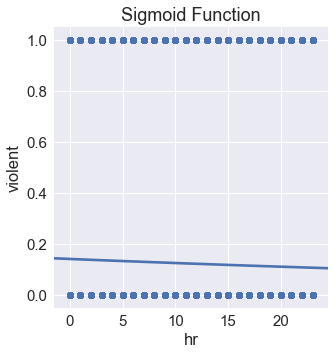

In [263]:
sns.lmplot(x="hr", y="violent", data = df, logistic = True);
plt.title("Sigmoid Function");

### Interpret Coefficients

$$ P(Y = 1) = p = \frac{exp(\beta_0 + \beta_1 x_1 + \dots + \beta_k x_k)}{1 + exp(\beta_0 + \beta_1 x_1 + \dots + \beta_k x_k)} $$  

* When $x_i$ takes the value 1am,  

$$\hat{p}_i = \frac {e^{-1.8077 - 0.0138 \times 1am}}{1 + e^{-1.8077 - 0.0138 \times 1am}} = 0.14 $$

**Model interpretation:** 

Increasing hour by 1 unit will decrease the odds of having a violent crime.

In [74]:
# Sigmoid function
p_violent = np.exp(-1.8077 - 0.0138*(1)) / ( 1 + np.exp(-1.8077 - 0.0138*(1)))
f'{p_violent:.2}'

'0.14'

In [75]:
# Sigmoid function
p_violent = np.exp(-1.8077 - 0.0138*(22)) / ( 1 + np.exp(-1.8077 - 0.0138*(22)))
f'{p_violent:.2}'

'0.11'

However, one would expect to have less violent crimes during the hours of 12am and 6am given that is when most people are asleep..

By plotting the distribution of violent crimes by the hour, it is clear that there is the effect of nightime, which makes sense given this data is based on a time series data. 

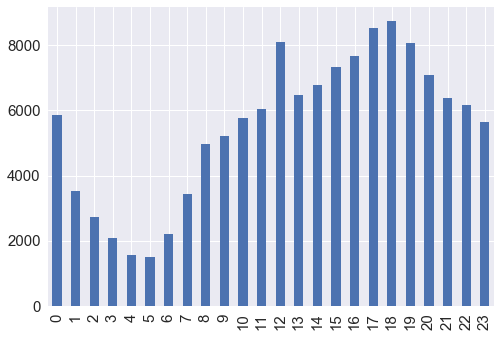

In [66]:
df[df["violent"] == 0]["hr"].value_counts().sort_index().plot(kind="bar");

Let's proove there is a nightime effect by looking at the proportion of crimes for 7am vs 7pm.

In [109]:
assault_7am = df[(df["category"] == "ASSAULT")& (df.hr == 7)]  
len(assault_7am)/len(df_assault)

0.026158279760585237

Probability of assault at 7am is 2.7% while assault at 7pm is 5%. 

In [111]:
assault_7pm = df[(df["category"] == "ASSAULT")& (df.hr == 19)] 
len(assault_7pm)/len(df_assault)

0.051355944727702656

Indeed, as we move to later in the day the probability of having assault is higher and we can say that there is a nightime effect. We will leave Time Series statistical modeling for Advanced Statistics class.

## GLM

In [131]:
#smf.glm("violent ~ lat + long", data=df).fit().summary()
smf.glm(formula="violent ~ lat + long + hr", data=df, family=sm.families.Binomial()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                violent   No. Observations:               149758
Model:                            GLM   Df Residuals:                   149754
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -54383.
Date:                Wed, 08 Mar 2017   Deviance:                   1.0877e+05
Time:                        14:48:05   Pearson chi2:                 1.50e+05
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1175.4115     42.947     27.369      0.000      1091.237  1259.586
lat            6.7114      0.323     20.794      0.000         6.079     7.344
long          -9.4157      0.324    -29.058      0.000       -10.051    -8.781
hr            -0.0134      0.001    -11.004      0.000        -0.016    -0.011
==============================================================================
"""

**Goodness of fit**: Pearson $\chi^2$

#### Interpret Coefficients

$$ P(Y = 1) = p = \frac{exp(\beta_0 + \beta_1 x_1 + \dots + \beta_k x_k)}{1 + exp(\beta_0 + \beta_1 x_1 + \dots + \beta_k x_k)} $$  

When $x_i$ takes the values:  

$$\hat{p}_i = \frac {e^{1175.4115 + 6.7114 \times latitude - 9.4157 \times longitude - 0.0134 \times hour}}{1 + e^{1175.4115 + 6.7114 \times latitude - 9.4157 \times longitude - 0.0134 \times hour}}$$ 

$\hat{p}_i$ = probability of violent crime

**Model interpretation:** 

Increasing $x_i$ will increase/decrease (depending on coeficient of $x_i$) the odds by (value from sigmoid function) of having a violent crime.